<a href="https://colab.research.google.com/github/cmansoo/funko-pop-cnn/blob/main/grid_search_example_using_a_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Activation, Dense, Flatten, InputLayer
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn.model_selection import ParameterGrid

In [2]:
# mount drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/SEIS 764/project") # change this to where your csv file is
!ls

Mounted at /content/drive
'764 final project images'		        image_gen.ipynb
 classfiers.ipynb			       'MansooNet - gender and initial training.ipynb'
 Copy_of_764project_gender_optimization.ipynb   MansooNet.h5
 data					       'MansooNet - SMOTE.ipynb'
 funko_file_map.csv			        model.png
 gender_after_smote_cnn2flatten.h5	       'SEIS764 project.ipynb'
 gender_after_smote_flatten2dense.h5	        test.csv
 gender_before_smote.h5			        test.gsheet
 gender_final.h5			       'Untitled document.gdoc'
'grid search example using a loop.ipynb'


In [3]:
# read
funko_df = pd.read_csv("funko_file_map.csv")
# remove unnecessary paths
funko_df["Image Path"] = funko_df["Image Path"].str.replace("drive/MyDrive/SEIS764/", "")

# change boolean columns to strings
for col in funko_df.columns.drop(["Image Path", "Gender", "Name"]):
  funko_df[col] = np.where(funko_df[col], "y", "n")

# split
train_df, test_df = train_test_split(funko_df, test_size=0.2, random_state=100)

In [4]:
# params
target_size = (224, 224)
batch_size = 8
num_class = 3

# generate data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col="Gender",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    subset="training"
)

test_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col="Gender",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

# define simple model, replace this with your loaded model
def create_model():
  model = Sequential()

  # conv 1
  model.add(InputLayer(input_shape = (224, 224, 3)))
  model.add(Conv2D(filters=16, kernel_size=(5,5)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(5,5)))

  # conv 2
  model.add(Conv2D(32, kernel_size=(3,3)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(3,3)))

  # flatten to add dense layers
  model.add(Flatten())

  # dense
  model.add(Dense(units=3200, activation="relu"))
  model.add(Dense(units=1600, activation="relu"))
  model.add(Dense(units=800, activation="relu"))
  model.add(Dense(units=400, activation="relu"))
  model.add(Dense(units=200, activation="relu"))
  model.add(Dense(units=100, activation="relu"))
  model.add(Dense(units=50, activation="relu"))
  model.add(Dense(units=25, activation="relu"))
  model.add(Dense(units=10, activation="relu"))
  model.add(Dense(units=num_class, activation="softmax"))

  return model

Found 170 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.


In [5]:
# define grid search parameters
params = {
    "epochs": [2, 3],
    "batch_size": [64, 96],
    "learning_rate": [0.01, 0.001],
    "momentum": [0.7, 0.9]
}

grid = list(ParameterGrid(params))

In [6]:
# to save model history
history = {"params":[], "history":[]}

# loop over grid search params
for x in grid:
  print("fitting a model with params {}".format(x))
  # compile
  model = create_model()
  model.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=x["learning_rate"], momentum=x["momentum"]), metrics=["accuracy"])
  # fit
  history["history"].append(
      model.fit(train_data, batch_size=x["batch_size"], epochs=x["epochs"], verbose=True, validation_data=test_data)
  )
  history["params"].append(x)

fitting a model with params {'batch_size': 64, 'epochs': 2, 'learning_rate': 0.01, 'momentum': 0.7}
Epoch 1/2
22/22 [==============================] - 125s 6s/step - loss: 0.7970 - accuracy: 0.6294 - val_loss: 0.9837 - val_accuracy: 0.6429
Epoch 2/2
22/22 [==============================] - 41s 2s/step - loss: 0.7757 - accuracy: 0.6588 - val_loss: 0.9602 - val_accuracy: 0.6429
fitting a model with params {'batch_size': 64, 'epochs': 2, 'learning_rate': 0.01, 'momentum': 0.9}
Epoch 1/2
22/22 [==============================] - 39s 2s/step - loss: 0.8733 - accuracy: 0.6000 - val_loss: 0.9332 - val_accuracy: 0.3333
Epoch 2/2
22/22 [==============================] - 36s 2s/step - loss: 0.7824 - accuracy: 0.6235 - val_loss: 0.8029 - val_accuracy: 0.6429
fitting a model with params {'batch_size': 64, 'epochs': 2, 'learning_rate': 0.001, 'momentum': 0.7}
Epoch 1/2
22/22 [==============================] - 40s 2s/step - loss: 0.8176 - accuracy: 0.6294 - val_loss: 1.0086 - val_accuracy: 0.6429
Epo

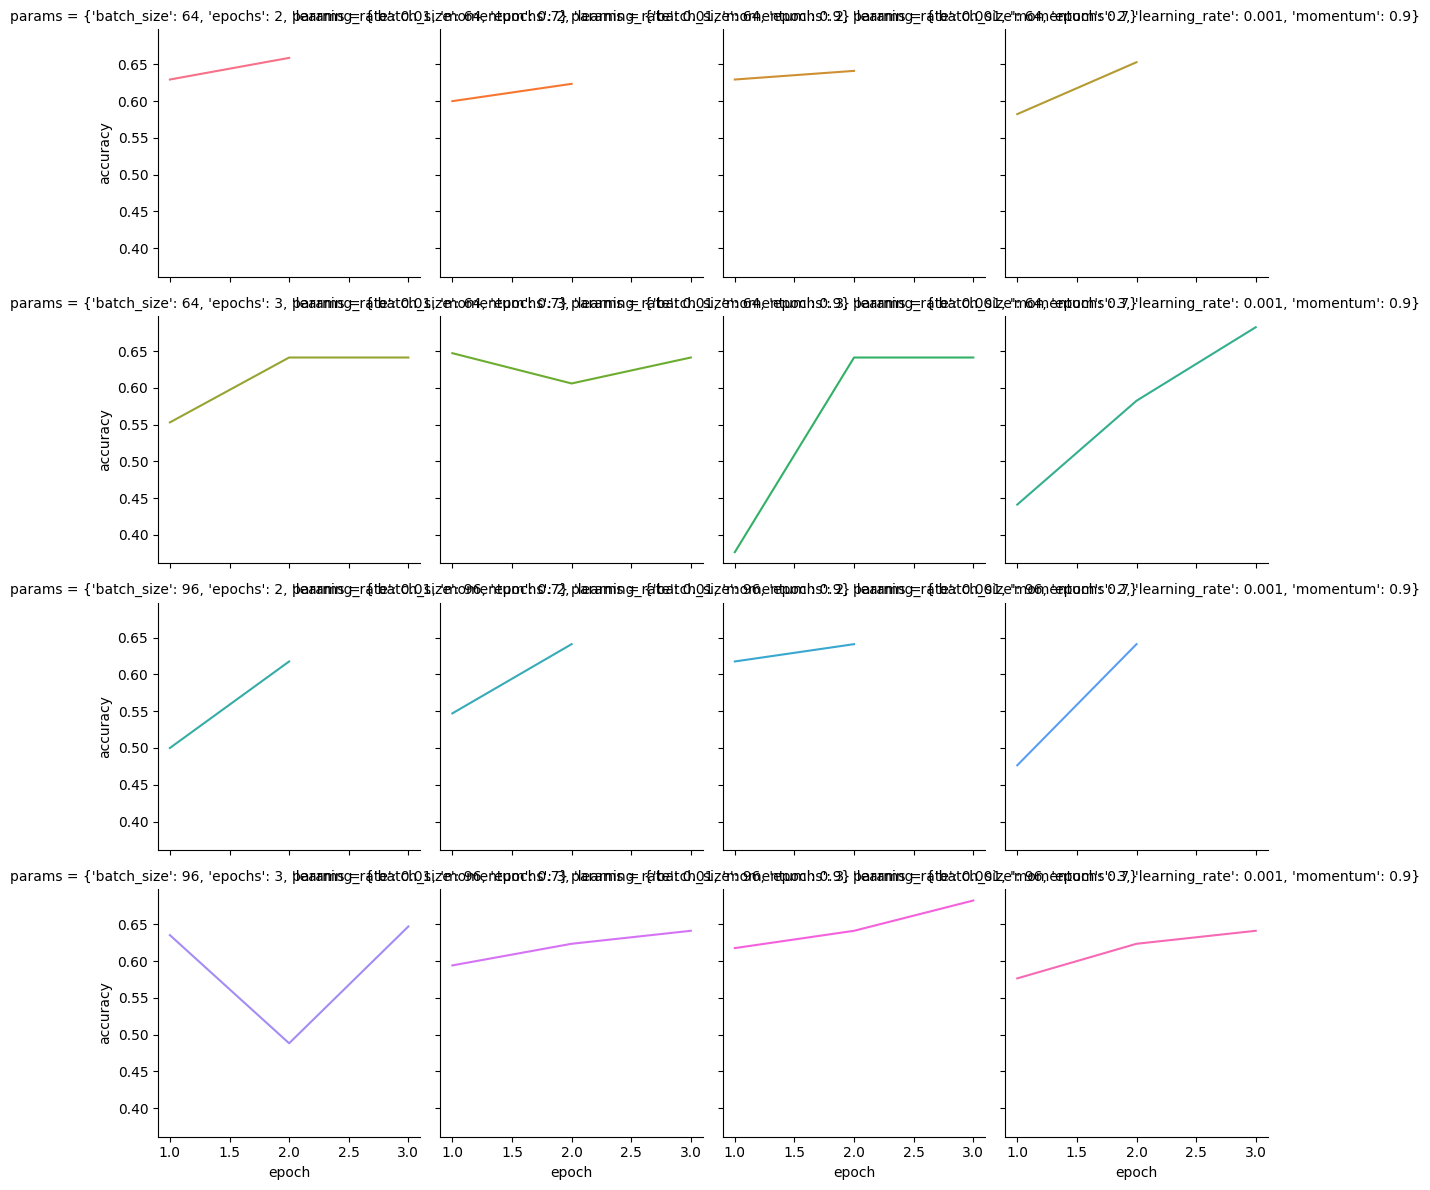

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot model history
accuracy_list = [h.history["accuracy"] for h in history["history"]]
history_df = pd.DataFrame(zip(history["params"], accuracy_list), columns=["params", "accuracy"])
history_df = history_df.explode("accuracy")
history_df["params"] = history_df.apply(lambda row: str(row["params"]), axis=1)
history_df["epoch"] = history_df.groupby(["params"]).cumcount()+1

g = sns.FacetGrid(history_df, col="params", col_wrap=4, hue="params")
g = g.map(sns.lineplot, "epoch", "accuracy")
plt.show()